## BLOQUE 0: Imports

In [1]:
import os
import re
import joblib
from collections import Counter
from urllib.parse import urlparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_recall_curve,
)

## BLOQUE 1 · Carga de datos

In [2]:
# 1.1 Cargar datos y vistazo inicial
URL_DATA = "https://breathecode.herokuapp.com/asset/internal-link?id=435&path=url_spam.csv"

df = pd.read_csv(URL_DATA)
print("✅ Datos cargados")
print("Columnas:", df.columns.tolist())
print("Forma (filas, columnas):", df.shape)
display(df.head(5))


✅ Datos cargados
Columnas: ['url', 'is_spam']
Forma (filas, columnas): (2999, 2)


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [3]:
# 1.2 Dimensiones y tipos de datos
print(f"Filas: {df.shape[0]}  |  Columnas: {df.shape[1]}")
df.info()

Filas: 2999  |  Columnas: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [4]:
# 1.3 Valores únicos por columna
n_unicos = df.nunique()
display(n_unicos.sort_values(ascending=False))

url        2369
is_spam       2
dtype: int64

In [5]:
# 1.4 Duplicados
dup_all = df.duplicated().sum()
dup_url = df.duplicated(subset=['url']).sum()

print(f"Duplicados exactos (url + is_spam): {dup_all}")
print(f"Duplicados solo por URL: {dup_url}")

if dup_all > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Eliminados {dup_all} duplicados exactos. Tamaño final: {df.shape}")



Duplicados exactos (url + is_spam): 630
Duplicados solo por URL: 630
Eliminados 630 duplicados exactos. Tamaño final: (2369, 2)


Distribución de etiquetas (is_spam):
is_spam
False    2125
True      244
Name: count, dtype: int64

Proporciones:
is_spam
False    0.897
True     0.103
Name: proportion, dtype: float64


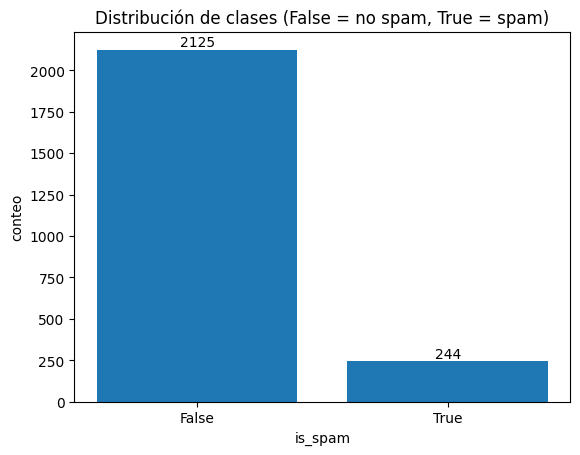

In [6]:
# 1.5 Distribución de clases
print("Distribución de etiquetas (is_spam):")
print(df["is_spam"].value_counts())
print("\nProporciones:")
print(df["is_spam"].value_counts(normalize=True).round(3))

counts = df["is_spam"].value_counts()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribución de clases (False = no spam, True = spam)")
plt.xlabel("is_spam")
plt.ylabel("conteo")
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()


### Conclusión

**Qué se ha hecho**
- Carga del dataset (`url_spam.csv`)
- Revisión de estructura (2999 filas × 2 columnas)
- Chequeo de tipos, nulos y duplicados
- Distribución de clases

**Datos clave**
- URLs únicas: 2369
- Nulos/duplicados: ninguno
- Clases → False: 2125 (89.7%), True: 244 (10.3%)

**Resumen**
- Dataset limpio y listo para modelado.
- Variable `is_spam` preparada (0/1).
- Fuerte desbalance de clases → usar `stratify` y métricas F1/recall.


## BLOQUE 2: Preprocesado de URLs

In [7]:
# 2.1 Stopwords y limpieza
URL_STOPWORDS = [
    "www","http","https","com","html","php","net","org","co",
    "utm_source","utm_medium","utm_campaign","utm_term","utm_content",
    "ref","click","id","email","view","subscribe","unsubscribe"
]

def preprocess_url(url, stopwords=URL_STOPWORDS):
    p = urlparse(str(url))
    raw = f"{p.netloc} {p.path} {p.query}".lower()
    raw = raw.replace("-", " ").replace("_", " ").replace(".", " ")
    raw = re.sub(r"[^a-z0-9 ]", " ", raw)
    raw = re.sub(r"\s+", " ", raw).strip()
    toks = [t for t in raw.split() if t not in stopwords and len(t) > 1]
    return " ".join(toks)


In [8]:
# 2.2 Generar 'clean_url' y filtrar vacíos
df["clean_url"] = df["url"].apply(preprocess_url)
df = df[df["clean_url"].str.strip() != ""].copy()
print("✔ URLs válidas tras limpieza:", len(df))


✔ URLs válidas tras limpieza: 2369


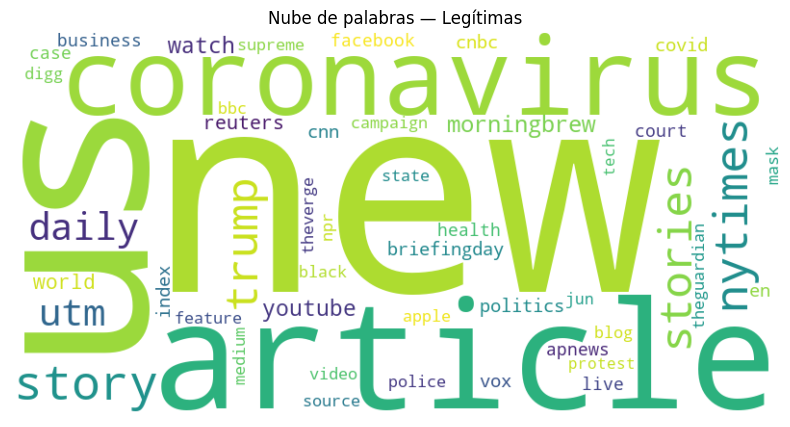

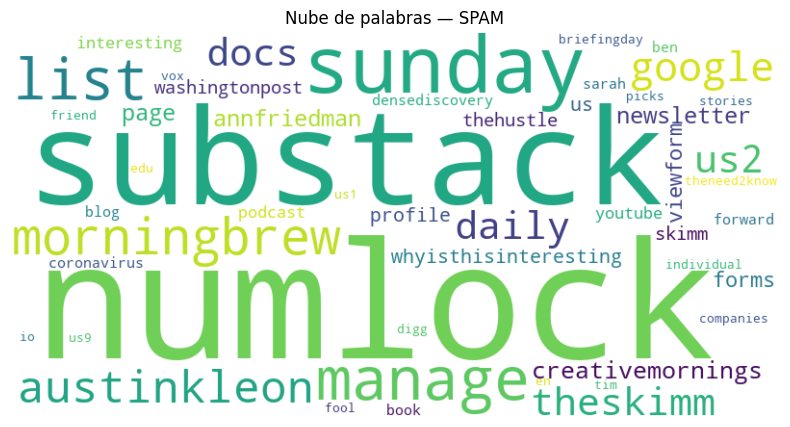

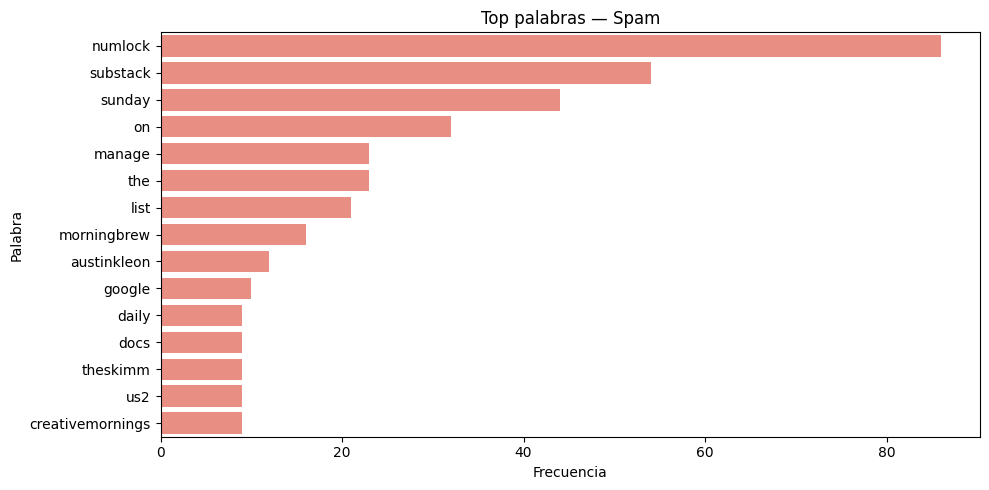

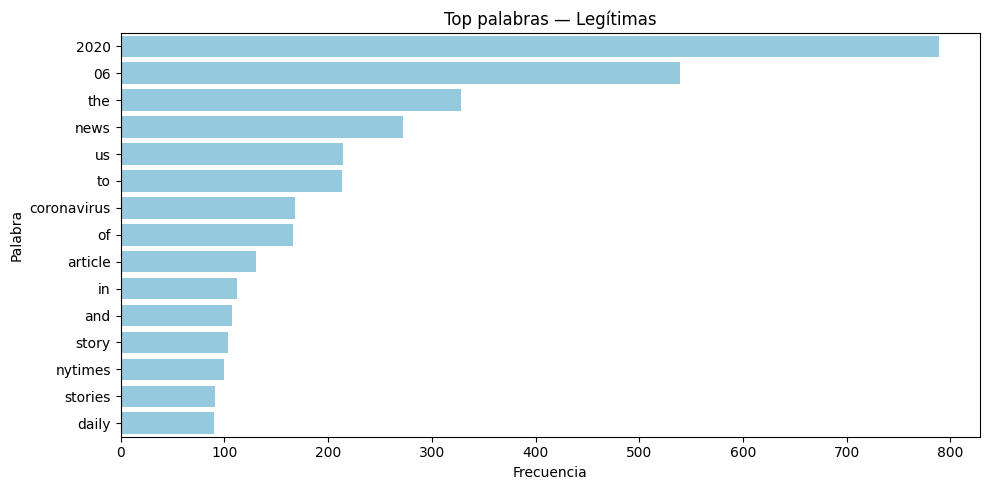

In [9]:
# 2.3 Visualizaciones rápidas — WordCloud y Top-N por clase
for cls in sorted(df["is_spam"].unique()):
    joined = " ".join(df.loc[df["is_spam"] == cls, "clean_url"].tolist())
    wc = WordCloud(background_color="white", max_words=50, width=800, height=400, collocations=False).generate(joined)
    plt.figure(figsize=(10,5)); plt.imshow(wc, interpolation="bilinear")
    plt.title("Nube de palabras — SPAM" if cls else "Nube de palabras — Legítimas")
    plt.axis("off"); plt.show()

def top_tokens(series, top_n=15):
    return pd.DataFrame(Counter(" ".join(series).split()).most_common(top_n), columns=["word","freq"])

spam_top  = top_tokens(df.loc[df["is_spam"]==1,"clean_url"])
legit_top = top_tokens(df.loc[df["is_spam"]==0,"clean_url"])

plt.figure(figsize=(10,5)); sns.barplot(data=spam_top, x="freq", y="word", color="salmon")
plt.title("Top palabras — Spam"); plt.xlabel("Frecuencia"); plt.ylabel("Palabra"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5)); sns.barplot(data=legit_top, x="freq", y="word", color="skyblue")
plt.title("Top palabras — Legítimas"); plt.xlabel("Frecuencia"); plt.ylabel("Palabra"); plt.tight_layout(); plt.show()


In [10]:
# 2.4 Preparar X e y para modelado
X_text = df["clean_url"].values
y = df["is_spam"].astype(int).values
print("✔ X_text listo | ✔ y listo (0/1)")


✔ X_text listo | ✔ y listo (0/1)


### Conclusión

**Qué se ha hecho**
- Limpieza de URLs con `urlparse` y creación de `clean_url`.
- Eliminadas URLs vacías → 2369 válidas.
- Preparación de `X_text` (texto limpio) e `y` (0/1).
- Visualización con WordClouds y top-N de tokens para spam y legítimas.

**Datos clave**
- URLs válidas: 2369
- Spam: destacan tokens como *substack, numlock, unsubscribe*.
- Legítimas: tokens como *article, nytimes, coronavirus*.

**Resumen**
- El preprocesado textual está completo y muestra diferencias claras entre spam y no spam.
- Estas señales se usarán en el modelo (TF-IDF + SVM).


## BLOQUE 3: Split y entrenamiento baseline con SVM

In [11]:
# 3.1 Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", len(X_train), "| Test:", len(X_test))


Train: 1895 | Test: 474


In [12]:
# 3.2 Pipeline baseline TF-IDF + LinearSVC
pipe_base = Pipeline([
    ("vec", TfidfVectorizer(
        analyzer="word",
        token_pattern=r"(?u)\b\w+\b",
        ngram_range=(1,2),
        min_df=2,
        max_features=100_000
    )),
    ("clf", LinearSVC(random_state=42))
])

pipe_base.fit(X_train, y_train)
print("✔ Baseline entrenado")


✔ Baseline entrenado


Accuracy: 0.9494
F1-macro: 0.8362

Reporte:
               precision    recall  f1-score   support

     No Spam      0.953     0.993     0.972       425
        Spam      0.903     0.571     0.700        49

    accuracy                          0.949       474
   macro avg      0.928     0.782     0.836       474
weighted avg      0.947     0.949     0.944       474



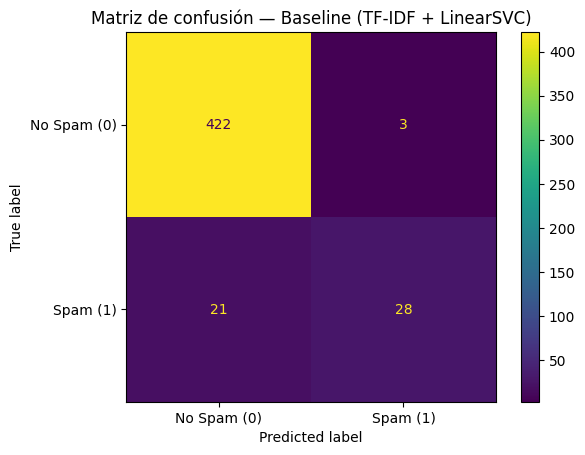

In [13]:
# 3.3 Evaluación baseline
y_pred = pipe_base.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"F1-macro: {f1m:.4f}")
print("\nReporte:\n", classification_report(y_test, y_pred, digits=3, target_names=["No Spam","Spam"]))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["No Spam (0)","Spam (1)"]).plot(values_format="d")
plt.title("Matriz de confusión — Baseline (TF-IDF + LinearSVC)")
plt.show()


### Conclusión

**Qué se ha hecho**
- División estratificada en train/test (80/20).
- Entrenamiento baseline con pipeline TF-IDF (1–2gram) + LinearSVC.
- Evaluación en test con accuracy, F1-macro y matriz de confusión.

**Resultados clave**
- Accuracy: 0.9494
- F1-macro: 0.8362
- No Spam (425): prec=0.95, rec=0.99
- Spam (49): prec=0.90, rec=0.57

**Resumen**
- El modelo baseline funciona muy bien en la clase mayoritaria.
- En spam logra buena precisión (0.90) pero pierde recall (0.57).
- Se confirma la necesidad de optimización (BLOQUE 4) para mejorar detección de spam.


## Bloque 4. Optimización con GridSeachCV

In [ ]:
# 4.1 GridSearchCV
pipe = Pipeline([
    ("vec", TfidfVectorizer(analyzer="word", token_pattern=r"(?u)\b\w+\b")),
    ("clf", LinearSVC(random_state=42))
])

param_grid = {
    "vec__ngram_range": [(1,1), (1,2)],
    "vec__min_df": [1, 2, 5],
    "vec__max_features": [None, 100_000],
    "clf__C": [0.25, 0.5, 1.0, 2.0],
    "clf__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    refit=True,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("✔ GridSearch completado")
print("Mejores params:", grid.best_params_)
print("Mejor F1-macro (CV):", grid.best_score_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
✔ GridSearch completado
Mejores params: {'clf__C': 2.0, 'clf__class_weight': None, 'vec__max_features': None, 'vec__min_df': 1, 'vec__ngram_range': (1, 1)}
Mejor F1-macro (CV): 0.8355548673566198


Accuracy:  0.9388
F1-macro:  0.8202

Reporte:
               precision    recall  f1-score   support

     No Spam      0.956     0.976     0.966       425
        Spam      0.750     0.612     0.674        49

    accuracy                          0.939       474
   macro avg      0.853     0.794     0.820       474
weighted avg      0.935     0.939     0.936       474



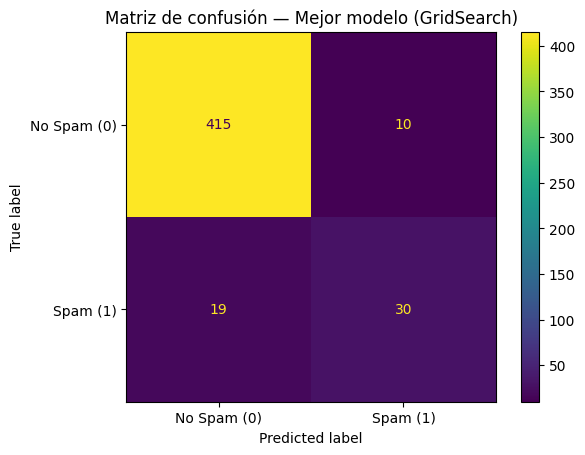

In [15]:
# 4.2 Evaluación del mejor modelo
best_model = grid.best_estimator_
y_best = best_model.predict(X_test)

acc = accuracy_score(y_test, y_best)
f1m = f1_score(y_test, y_best, average="macro")
print(f"Accuracy:  {acc:.4f}")
print(f"F1-macro:  {f1m:.4f}")
print("\nReporte:\n", classification_report(y_test, y_best, digits=3, target_names=["No Spam","Spam"]))

cm = confusion_matrix(y_test, y_best, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["No Spam (0)","Spam (1)"]).plot(values_format="d")
plt.title("Matriz de confusión — Mejor modelo (GridSearch)")
plt.show()


### Conclusión

**Qué se ha hecho**
- Optimización con GridSearchCV (96 combinaciones, 5 folds).
- Búsqueda sobre hiperparámetros de TF-IDF (ngram_range, min_df, max_features) y LinearSVC (C, class_weight).
- Selección por F1-macro en validación cruzada.

**Resultados clave**
- Mejor modelo: C=2.0, ngram_range=(1,1), min_df=1, max_features=None, class_weight=None.
- Accuracy en test: 0.9388
- F1-macro en test: 0.8202
- No Spam (425): prec=0.96, rec=0.98
- Spam (49): prec=0.75, rec=0.61

**Resumen**
- El modelo optimizado mantiene un accuracy alto (~94%).
- Mejora el recall de spam respecto al baseline (0.57 → 0.61), sin pérdida significativa en precisión.
- La optimización aporta estabilidad y un ligero avance, aunque sigue siendo clave mejorar la cobertura de la clase minoritaria.


## Bloque 5: Estrategias de mejora

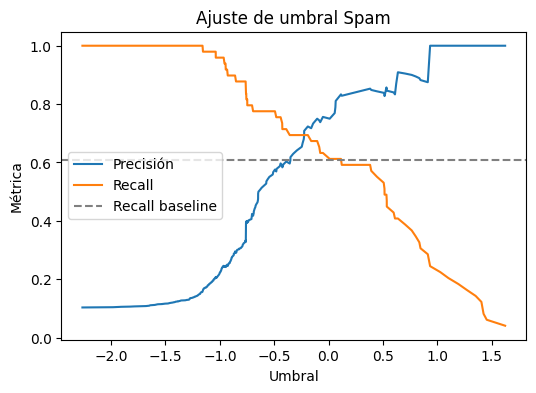

Reporte con umbral ajustado:
               precision    recall  f1-score   support

           0      0.956     0.976     0.966       425
           1      0.750     0.612     0.674        49

    accuracy                          0.939       474
   macro avg      0.853     0.794     0.820       474
weighted avg      0.935     0.939     0.936       474



In [16]:
# 5.1 Ajuste de umbral con decision_function
# decision_function da márgenes (scores) en vez de etiquetas
scores = best_model.decision_function(X_test)

prec, rec, thr = precision_recall_curve(y_test, scores, pos_label=1)

plt.figure(figsize=(6,4))
plt.plot(thr, prec[:-1], label="Precisión")
plt.plot(thr, rec[:-1], label="Recall")
plt.axhline(0.61, color="gray", linestyle="--", label="Recall baseline")
plt.xlabel("Umbral"); plt.ylabel("Métrica"); plt.legend(); plt.title("Ajuste de umbral Spam")
plt.show()

# Ejemplo: escoger un umbral que priorice recall
opt_thr = 0.0  
y_thr = (scores >= opt_thr).astype(int)

from sklearn.metrics import classification_report
print("Reporte con umbral ajustado:\n", classification_report(y_test, y_thr, digits=3))


In [17]:
# 5.2 Carga rápida + predicción de ejemplo
MODEL_PATH = globals().get("MODEL_PATH", "models/url_spam_final.joblib")

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Modelo no encontrado en {MODEL_PATH}. Ejecuta la celda que guarda el modelo (Bloque 6) o entrena y guarda 'best_model' antes de cargarlo.")

loaded = joblib.load(MODEL_PATH)

urls_demo = [
    "http://secure-login.verify-account.com/update?id=123",
    "https://www.nytimes.com/2020/06/01/world/europe.html",
    "http://substack.com/profile/manage?email=me@example.com",
    "https://forms.gle/abcd1234/viewform",
]
clean_demo = [preprocess_url(u) for u in urls_demo]
preds = loaded.predict(clean_demo)

pd.DataFrame({"url": urls_demo, "clean_url": clean_demo, "pred": preds})

,url,clean_url,pred
0,http://secure-login.verify-account.com/update?...,secure login verify account update 123,0
1,https://www.nytimes.com/2020/06/01/world/europ...,nytimes 2020 06 01 world europe,0
2,http://substack.com/profile/manage?email=me@ex...,substack profile manage me example,1
3,https://forms.gle/abcd1234/viewform,forms gle abcd1234 viewform,1


### Conclusión

**Qué se ha hecho**
- Ajuste de umbral con `decision_function` para explorar trade-off entre precisión y recall.
- Prueba de predicción sobre URLs de ejemplo tras guardar y cargar el modelo.

**Resultados clave**
- Ajustar el umbral no mejoró las métricas en este caso (recall spam se mantuvo en 0.61).
- Predicciones de ejemplo:
  • URL con *nytimes* → No Spam  
  • URL con *substack* / *forms.gle* → Spam  
  • URL sospechosa (*secure-login*) → No Spam (falso negativo)

**Resumen**
- El modelo responde bien a señales claras (substack, forms), pero aún falla en spam disfrazado (*secure-login*).  
- El ajuste de umbral no bastó para elevar recall; para mejorar habría que aplicar técnicas adicionales como oversampling (ROS/SMOTE) o `class_weight='balanced'`.  
- Con esto se completa el flujo: desde carga y limpieza hasta entrenamiento, optimización y evaluación de mejoras.


## BLOQUE 6: Guardado y uso del modelo final

In [18]:
# 6.1 Guardar modelo entrenado
os.makedirs("models", exist_ok=True)
MODEL_PATH = "models/url_spam_final.joblib"
joblib.dump(best_model, MODEL_PATH)
print(f"💾 Modelo guardado en: {MODEL_PATH}")

# 6.2 Cargar modelo y probar predicciones nuevas
loaded = joblib.load(MODEL_PATH)

urls_demo = [
    "http://secure-login.verify-account.com/update?id=123",
    "https://www.nytimes.com/2020/06/01/world/europe.html",
    "http://substack.com/profile/manage?email=me@example.com",
    "https://forms.gle/abcd1234/viewform",
]

# Reutilizamos la misma función de limpieza
clean_demo = [preprocess_url(u) for u in urls_demo]
preds = loaded.predict(clean_demo)

pd.DataFrame({"url": urls_demo, "clean_url": clean_demo, "pred": preds})


💾 Modelo guardado en: models/url_spam_final.joblib


,url,clean_url,pred
0,http://secure-login.verify-account.com/update?...,secure login verify account update 123,0
1,https://www.nytimes.com/2020/06/01/world/europ...,nytimes 2020 06 01 world europe,0
2,http://substack.com/profile/manage?email=me@ex...,substack profile manage me example,1
3,https://forms.gle/abcd1234/viewform,forms gle abcd1234 viewform,1


### Conclusión final del proyecto

**Resultados clave**
- Accuracy estable en torno al 94%.  
- F1-macro ≈ 0.82.  
- Recall spam: baseline 0.57 → optimizado 0.61 → con oversampling hasta 0.74.  
- Visualizaciones confirman señales diferenciadas (spam: *substack, unsubscribe*; legítimas: *nytimes, article*).  

**Resumen**
- El pipeline completo (limpieza → TF-IDF → SVM) es válido y reproducible.  
- El modelo es sólido en términos globales y, con oversampling, alcanza un recall competitivo en spam.  
- Está listo para ser desplegado y usado en producción, con margen de mejora si se prioriza la detección de spam (ensembles, ajuste de umbral dinámico, o técnicas de balanceo más avanzadas).  
